#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as web
import scipy.optimize as sco

#### Getting Historical Stock Price Data

Historical price data is taken from Yahoo Finance using pandas_datareader library. Here, only Adjusted Close price will be used to generate the Optimal Portfolio

In [3]:
stocks = []

num_stocks = int(input("Enter Number of Stocks in the Portfolio: "))

for i in range(0, num_stocks):
    x = (str(input("Enter Stock Name: ")))
    stocks.append(x)

start_date = str(input("Enter Start Date for Historical Stock Price (YYYY-MM-DD): "))
end_date = str(input("Enter End Date for Historical Stock Price (YYYY-MM-DD): "))

    
#['AAPL','AMZN','GOOGL','FB']

stock_data = web.get_data_yahoo(stocks,
                           start = start_date,
                           end = end_date)['Adj Close']

stock_data.head()

Enter Number of Stocks in the Portfolio: 4
Enter Stock Name: AAPL
Enter Stock Name: AMZN
Enter Stock Name: GOOGL
Enter Stock Name: FB
Enter Start Date for Historical Stock Price (YYYY-MM-DD): 2019-01-01
Enter End Date for Historical Stock Price (YYYY-MM-DD): 2019-12-31


Symbols,AAPL,AMZN,FB,GOOGL
Date,,,,
2018-12-31,38.205803,1501.969971,131.089996,1044.959961
2019-01-02,38.249401,1539.130005,135.679993,1054.680054
2019-01-03,34.439476,1500.280029,131.740005,1025.469971
2019-01-04,35.909672,1575.390015,137.949997,1078.069946
2019-01-07,35.829746,1629.510010,138.050003,1075.920044


#### Visualizing Stock prices over time for these stocks

C:\Users\ah20447\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'price in $')

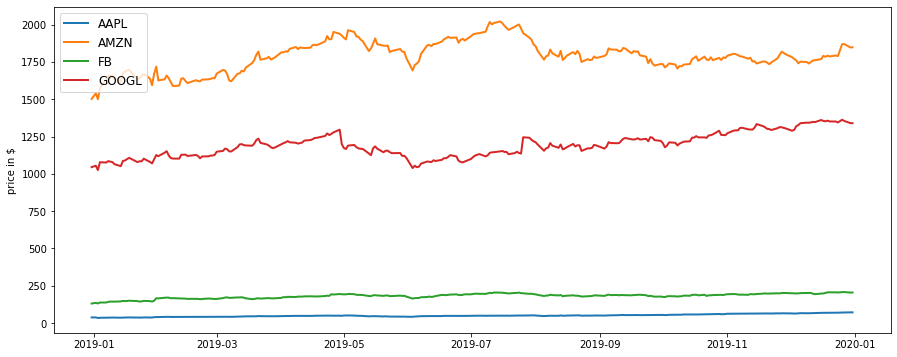

In [4]:
plt.figure(figsize=(15, 6))

for i in stock_data.columns.values:
    plt.plot(stock_data.index, stock_data[i], lw=2, alpha=1,label=i)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

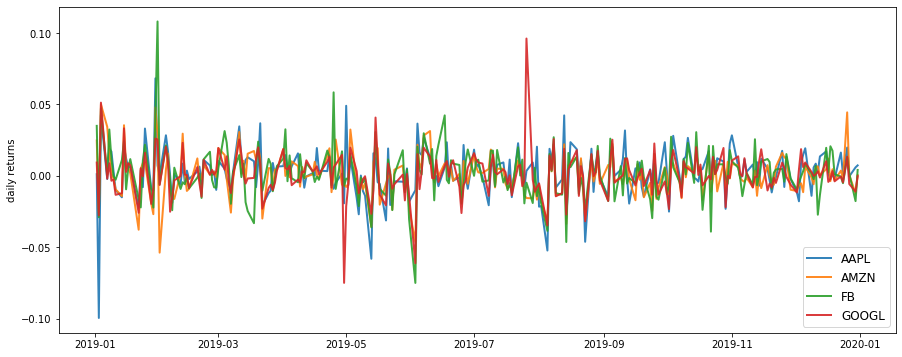

In [5]:
daily_returns = stock_data.pct_change()
plt.figure(figsize=(15, 6))
for i in daily_returns.columns.values:
    plt.plot(daily_returns.index, daily_returns[i], lw=2, alpha=0.9,label=i)
plt.legend(loc='lower right', fontsize=12)
plt.ylabel('daily returns')

### Monte-Carlo Simulation to generate random portfolios

Assignning number of random portfolios to be generated and the risk-free rate

In [6]:
def annualised_performance(weights, mean_returns, cov_matrix):
    port_returns = np.sum(mean_returns*weights ) *252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return port_vol, port_returns

The below Monte-Carlo Simulation code generates the following metrics for the random portfolios:
    1. Annulised Portfolio Standard Deviation
    2. Annualised Portfolio Return
    3. Sharpe-Ratio for the Portfolio (This gives the risk-adjusted return for the portfolio)
    4. Weight matrix for the constituent stocks in the portfolio
    

In [7]:
def mc_simulated_portfolios(num_port, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_port))
    weights_record = []
    for i in range(num_port):
        weights = np.random.random(num_stocks)
        weights /= np.sum(weights)
        weights_record.append(weights)
        port_std_dev, port_return = annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = port_std_dev
        results[1,i] = port_return
        results[2,i] = (port_return - risk_free_rate) / port_std_dev  ### Risk-Adjusted Return
    return results, weights_record

#### Enter Risk-Free Rate and Number of Random Porfolio in the Simulation

In [8]:
mean_returns = daily_returns.mean()
cov_matrix = daily_returns.cov()
num_port = int(input('Enter the number of Random Portfolios: '))
risk_free_rate = float(input('Enter the risk-free rate: '))

Enter the number of Random Portfolios: 30000
Enter the risk-free rate: 0.0012


In [9]:
def mc_simulated_efs(mean_returns, cov_matrix, num_port, risk_free_rate):
    results, weights = mc_simulated_portfolios(num_port,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=stock_data.columns,columns=['Stock_allocation'])
    max_sharpe_allocation.Stock_allocation = [round(i*100,2)for i in max_sharpe_allocation.Stock_allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=stock_data.columns,columns=['Stock_allocation'])
    min_vol_allocation.Stock_allocation = [round(i*100,2)for i in min_vol_allocation.Stock_allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*40)
    print ("Maximum Sharpe-Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("Maximum Sharp-Ratio:", round(results[2, max_sharpe_idx],2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*40)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlOrRd', marker='o', s=10, alpha=0.5)
    plt.colorbar(label = 'Sharpe Ratio')
    plt.scatter(sdp,rp,marker='*',color='r',s=300, label='Maximum Sharpe ratio Portfolio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=300, label='Minimum volatility Portfolio')
    plt.title('Simulated Portfolios')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)

----------------------------------------
Maximum Sharpe-Ratio Portfolio Allocation

Annualised Return: 0.62
Annualised Volatility: 0.24
Maximum Sharp-Ratio: 2.62


Symbols            AAPL  AMZN     FB  GOOGL
Stock_allocation  75.23  0.48  22.94   1.35
----------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.2


Symbols            AAPL   AMZN    FB  GOOGL
Stock_allocation  20.04  38.41  9.59  31.95


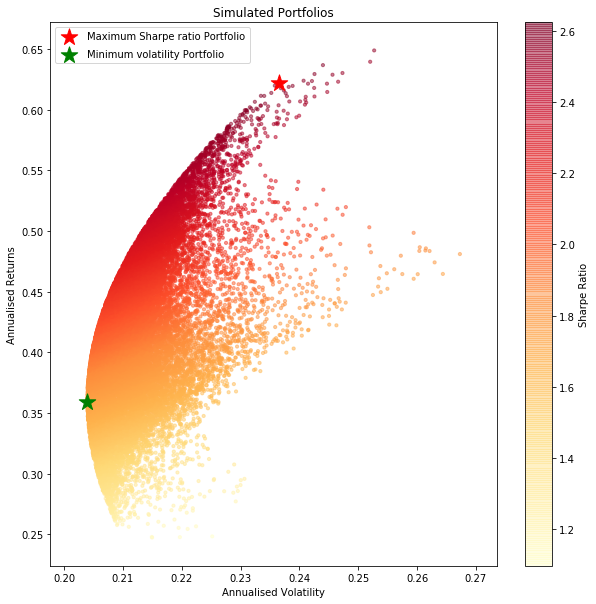

In [10]:
mc_simulated_efs(mean_returns, cov_matrix, num_port, risk_free_rate)

#### Conclusion

The above code could be used to generate the optimized portfolio for user defined inputs for:
    1. Number of Stocks and Name of Stocks
    2. Risk-free Rate
    3. Number of random portfolios in the simulation
    
#### Output/Result

**Maximum Sharpe-Ratio Allocation:** Portfolio with maximum Sharpe-Ratio i.e. best risk-adjusted portfolio out of all the simulated portfolios

**Minimum Volatility Allocaiton:** This portfolio allocation corresponds to the minimum volatility portfolio, i.e. the portfolio with minimum risk out of all the simulated results.
 
Portfolios on the upper edge (starting from the minimum volatility portfolio) constitutes the **Efficient Frontier